# Install Library

[RDKit ](https://github.com/rdkit/rdkit)

[DGL](https://github.com/dmlc/dgl/)

[DGL-LifeSci](https://github.com/awslabs/dgl-lifesci)





In [ ]:
%%capture
!pip install rdkit-pypi
!pip install dgllife
!pip install --pre dgl-cu113 dglgo -f https://data.dgl.ai/wheels-test/repo.html

# Import Library

In [1]:
import dgl 
import sys
import torch
import random
import cv2
import statistics
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

from tensorflow.keras.utils import to_categorical
from dgllife.model import MLPPredictor
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, AttentiveFPAtomFeaturizer
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split

from utils.general import DATASET, get_dataset, separate_active_and_inactive_data, get_embedding_vector_class, count_lablel,data_generator
from utils.gcn_pre_trained import get_tox21_model
from model.heterogeneous_siamese_tox21 import siamese_model_attentiveFp_tox21, siamese_model_Canonical_tox21

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [2]:
cache_path='./tox21_dglgraph.bin'

df = get_dataset("tox21")
id = df['mol_id']
df = df.drop(columns=['mol_id'])

In [5]:
tox21_tasks = df.columns.values[:12].tolist()

In [6]:
df

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC(O)(P(=O)(O)O)P(=O)(O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
7827,1.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...
7828,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...
7829,1.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...


In [7]:
one = []
zero = []
nan = []
 
for task in tox21_tasks:
    a = list(df[task].value_counts(dropna=False).to_dict().values())
    zero.append(a[0])
    nan.append(a[1])
    one.append(a[2])
    print(task ,"one:" ,a[2] ," zero:", a[0], " NAN:",a[1])


NR-AR one: 309  zero: 6956  NAN: 566
NR-AR-LBD one: 237  zero: 6521  NAN: 1073
NR-AhR one: 768  zero: 5781  NAN: 1282
NR-Aromatase one: 300  zero: 5521  NAN: 2010
NR-ER one: 793  zero: 5400  NAN: 1638
NR-ER-LBD one: 350  zero: 6605  NAN: 876
NR-PPAR-gamma one: 186  zero: 6264  NAN: 1381
SR-ARE one: 942  zero: 4890  NAN: 1999
SR-ATAD5 one: 264  zero: 6808  NAN: 759
SR-HSE one: 372  zero: 6095  NAN: 1364
SR-MMP one: 918  zero: 4892  NAN: 2021
SR-p53 one: 423  zero: 6351  NAN: 1057


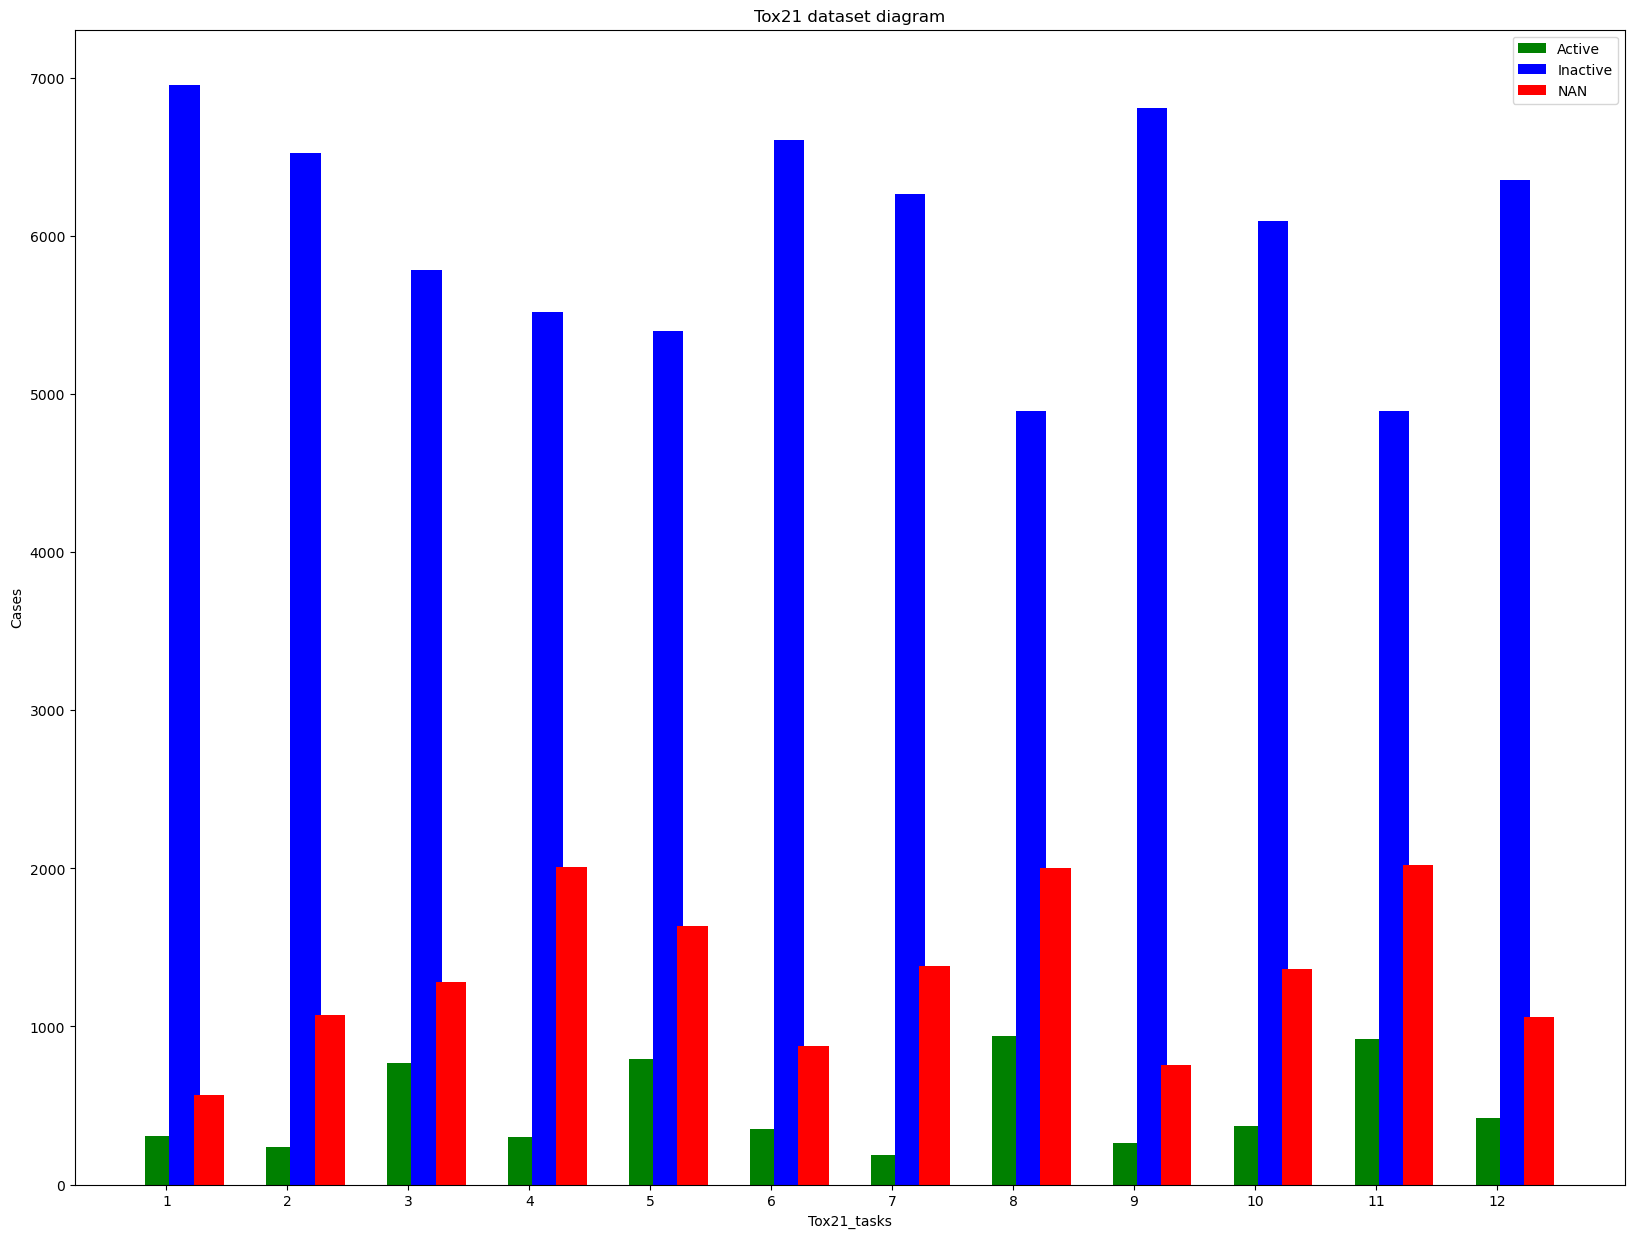

In [8]:
# Importing the matplotlib library
import numpy as np
import matplotlib.pyplot as plt
# Declaring the figure or the plot (y, x) or (width, height)
plt.figure(figsize=[20, 15])

X = np.arange(1,len(tox21_tasks)+1)
plt.bar(X + 0.2, one, color = 'g', width = 0.25)
plt.bar(X + 0.4, zero, color = 'b', width = 0.25)
plt.bar(X + 0.6, nan, color = 'r', width = 0.25)

# Creating the legend of the bars in the plot
plt.legend(['Active' , 'Inactive' ,'NAN'])
# Overiding the x axis with the country names
plt.xticks([i + 0.25 for i in range(1,13)], X)
# Giving the tilte for the plot
plt.title("Tox21 dataset diagram")
# Namimg the x and y axis
plt.xlabel('Tox21_tasks')
plt.ylabel('Cases')
# Saving the plot as a 'png'
plt.savefig('4BarPlot.png')
# Displaying the bar plot
plt.show()

# Required functions

In [10]:
def create_dataset_with_gcn(ds, class_embed_vector, GCN, tasks):

    created_data = []
    data = np.arange(len(tasks))
    onehot_encoded = to_categorical(data)
    for numberTask, dataset in enumerate(ds):
        for i, data in enumerate(dataset):
            smiles, g, label, mask = data
            g = g.to(device)
            g = dgl.add_self_loop(g)
            graph_feats = g.ndata.pop('h')
            embbed = GCN(g, graph_feats)
            embbed = embbed.to('cpu')
            embbed = embbed.detach().numpy()
            a = ( embbed, onehot_encoded[numberTask], class_embed_vector[numberTask], label, tasks[numberTask])
            created_data.append(a)
    print('Data created!!')
    return created_data 

# **Drug-based strategy with BioAct-Het**

## Classification with BioAct-Het and AttentiveFp GCN

In [11]:
model_name = 'GCN_attentivefp_Tox21'
gcn_model = get_tox21_model(model_name)
gcn_model.eval()
gcn_model = gcn_model.to(device)

Pretrained model loaded


In [13]:
from sklearn.model_selection import KFold

Epoch_S = 10

def evaluate_model(df, k = 10 , shuffle = False, tasks = tox21_tasks):
    result =[]    

    kf = KFold(n_splits=10, shuffle= shuffle, random_state=None)
    
    for train_index, test_index in kf.split(df):

        train = df.iloc[train_index]
        test =  df.iloc[test_index]
        
        #Calculation of embedded vectors for each class
        df_train_positive, df_train_negative = Separate_active_and_inactive_data(train, tasks)
        df_test_positive, df_test_negative = Separate_active_and_inactive_data(test, tasks)
        
        dataset_positive_train = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_train_positive]
        dataset_negative_train = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_train_negative]   
        dataset_positive_test = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_test_positive]
        dataset_negative_test = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_test_negative]
        
        embed_class_tox21_train = get_embedding_vector_class(dataset_positive_train, dataset_negative_train, radius=2, size = 512)
        embed_class_tox21_test = get_embedding_vector_class(dataset_positive_test, dataset_negative_test, radius=2, size = 512)
       
        #create_dataset       
        train_notnan = del_nan (train, tasks)
        test_notnan = del_nan (test, tasks)

        train_dataset = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in train_notnan]
        test_dataset = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in test_notnan]
          
        train_ds = create_dataset_with_gcn(train_dataset, embed_class_tox21_train, gcn_model, tasks)
        valid_ds = create_dataset_with_gcn(test_dataset, embed_class_tox21_test, gcn_model, tasks)
        
        label_pos , label_neg, _ , _ = count_lablel(train_ds)
        print(f'train positive label: {label_pos} - train negative label: {label_neg}')
        
        train_ds = up_and_down_Samplenig(train_ds, scale_downsampling = 0.5)
        
        label_pos , label_neg , _ , _ = count_lablel(train_ds)
        print(f'up and down sampling => train positive label: {label_pos} - train negative label: {label_neg}')

        label_pos , label_neg, _ , _ = count_lablel(valid_ds)
        print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

        l_train = []
        r_train = []
        lbls_train = []
        
        l_valid = []
        r_valid = []
        lbls_valid = []

        for i , data in enumerate(train_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_train.append(embbed_drug[0])
            r_train.append(embbed_task)
            lbls_train.append(lbl.tolist())
        
        for i , data in enumerate(valid_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_valid.append(embbed_drug[0])
            r_valid.append(embbed_task)
            lbls_valid.append(lbl.tolist())

        l_train = np.array(l_train).reshape(-1,512,1)
        r_train = np.array(r_train).reshape(-1,512,1)
        lbls_train = np.array(lbls_train)

        l_valid = np.array(l_valid).reshape(-1,512,1)
        r_valid = np.array(r_valid).reshape(-1,512,1)
        lbls_valid = np.array(lbls_valid)

        # create neural network model
        siamese_net = siamese_model_attentiveFp_tox21()
        history = History()
        P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])

        for j in range(100):
            C=1
            Before = int(P.history['accuracy'][-1]*100)
            for i in range(2,Epoch_S+1):
                if  int(P.history['accuracy'][-i]*100)== Before:
                    C=C+1
                else:
                    C=1
                Before=int(P.history['accuracy'][-i]*100)
                print(Before)
            if C==Epoch_S:
                break
            P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])
        print(j+1)
        
        score  = siamese_net.evaluate([l_valid,r_valid],lbls_valid, verbose=1)
        a = (score[1],score[4])
        result.append(a)
    
    return result
 
 
scores = evaluate_model(df, 10, False, tox21_tasks)

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/6241
Processing molecule 2000/6241
Processing molecule 3000/6241
Processing molecule 4000/6241
Processing molecule 5000/6241
Processing molecule 6000/6241
Processing dgl graphs from scratch...
Processing molecule 1000/5859
Processing molecule 2000/5859
Processing molecule 3000/5859
Processing molecule 4000/5859
Processing molecule 5000/5859
Processing dgl graphs from scratch...
Processing molecule 1000/5202
Processing molecule 2000/5202
Processing molecule 3000/5202
Processing

Processing molecule 5000/5878
Processing dgl graphs from scratch...
Processing molecule 1000/5221
Processing molecule 2000/5221
Processing molecule 3000/5221
Processing molecule 4000/5221
Processing molecule 5000/5221
Processing dgl graphs from scratch...
Processing molecule 1000/4983
Processing molecule 2000/4983
Processing molecule 3000/4983
Processing molecule 4000/4983
Processing dgl graphs from scratch...
Processing molecule 1000/4871
Processing molecule 2000/4871
Processing molecule 3000/4871
Processing molecule 4000/4871
Processing dgl graphs from scratch...
Processing molecule 1000/5951
Processing molecule 2000/5951
Processing molecule 3000/5951
Processing molecule 4000/5951
Processing molecule 5000/5951
Processing dgl graphs from scratch...
Processing molecule 1000/5635
Processing molecule 2000/5635
Processing molecule 3000/5635
Processing molecule 4000/5635
Processing molecule 5000/5635
Processing dgl graphs from scratch...
Processing molecule 1000/4402
Processing molecule 20

Exception ignored in: <function ObjectBase.__del__ at 0x000002C1F4277B88>
Traceback (most recent call last):
  File "C:\Users\Ali\anaconda3\envs\thesis\lib\site-packages\dgl\_ffi\_ctypes\object.py", line 57, in __del__
    check_call(_LIB.DGLObjectFree(self.handle))
KeyboardInterrupt


Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...


KeyboardInterrupt: 

#### Dropout = 0.3 and downsampling = 0.5 

In [14]:
scores

[(0.8309966921806335, 0.771041989326477),
 (0.8410621881484985, 0.7880051732063293),
 (0.8567735552787781, 0.7801276445388794),
 (0.8227604627609253, 0.8001449108123779),
 (0.8309343457221985, 0.8106696605682373),
 (0.8623507022857666, 0.7970605492591858),
 (0.8101316094398499, 0.7712388634681702),
 (0.8488796353340149, 0.787397563457489),
 (0.8429239988327026, 0.808811604976654),
 (0.8173492550849915, 0.796164870262146)]

In [15]:
acc = []
auc = []
for i in scores:
    acc.append(i[0])
    auc.append(i[1])

print(f'accuracy= {np.mean(acc)} AUC= {np.mean(auc)} STD_AUC= {np.std(auc)}')

accuracy= 0.8364162445068359 AUC= 0.7910662829875946 STD_AUC= 0.01334211294060164


## Classification with BioAct-Het and Canonical GCN 

In [24]:
model_name = 'GCN_canonical_Tox21'
gcn_model = get_tox21_model(model_name)

gcn_model.eval()
gcn_model = gcn_model.to(device)

Pretrained model loaded


In [26]:
from sklearn.model_selection import KFold

Epoch_S = 10

def evaluate_model(df, k = 10 , shuffle = False, tasks = tox21_tasks):
    result =[]    

    kf = KFold(n_splits=10, shuffle= shuffle, random_state=None)
    
    for train_index, test_index in kf.split(df):

        train = df.iloc[train_index]
        test =  df.iloc[test_index]
        
        #Calculation of embedded vectors for each class
        df_train_positive, df_train_negative = Separate_active_and_inactive_data(train, tasks)
        df_test_positive, df_test_negative = Separate_active_and_inactive_data(test, tasks)
        
        dataset_positive_train = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_train_positive]
        dataset_negative_train = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_train_negative]    
        dataset_positive_test = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_test_positive]
        dataset_negative_test = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_test_negative]
        
        embed_class_tox21_train = get_embedding_vector_class(dataset_positive_train, dataset_negative_train, radius=2, size = 512)
        embed_class_tox21_test = get_embedding_vector_class(dataset_positive_test, dataset_negative_test, radius=2, size = 512)
       
        #create_dataset       
        train_notnan = del_nan (train, tasks)
        test_notnan = del_nan (test, tasks)

        train_dataset = [DATASET(d, smiles_to_bigraph, CanonicalAtomFeaturizer(), cache_file_path = cache_path) for d in train_notnan]
        test_dataset = [DATASET(d, smiles_to_bigraph, CanonicalAtomFeaturizer(), cache_file_path = cache_path) for d in test_notnan]
          
        train_ds = create_dataset_with_gcn(train_dataset, embed_class_tox21_train, gcn_model, tasks)
        valid_ds = create_dataset_with_gcn(test_dataset, embed_class_tox21_test, gcn_model, tasks)
        
        label_pos , label_neg, _ , _ = count_lablel(train_ds)
        print(f'train positive label: {label_pos} - train negative label: {label_neg}')
        
        train_ds = up_and_down_Samplenig(train_ds, scale_downsampling = 0.5)
        
        label_pos , label_neg , _ , _ = count_lablel(train_ds)
        print(f'up and down sampling => train positive label: {label_pos} - train negative label: {label_neg}')

        label_pos , label_neg, _ , _ = count_lablel(valid_ds)
        print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

        l_train = []
        r_train = []
        lbls_train = []
        
        l_valid = []
        r_valid = []
        lbls_valid = []

        for i , data in enumerate(train_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_train.append(embbed_drug[0])
            r_train.append(embbed_task)
            lbls_train.append(lbl.tolist())
        
        for i , data in enumerate(valid_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_valid.append(embbed_drug[0])
            r_valid.append(embbed_task)
            lbls_valid.append(lbl.tolist())

        l_train = np.array(l_train).reshape(-1,128,1)
        r_train = np.array(r_train).reshape(-1,512,1)
        lbls_train = np.array(lbls_train)

        l_valid = np.array(l_valid).reshape(-1,128,1)
        r_valid = np.array(r_valid).reshape(-1,512,1)
        lbls_valid = np.array(lbls_valid)

        # create neural network model
        siamese_net = siamese_model_Canonical_tox21()
        
        history = History()
        P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])

        for j in range(100):
            C=1
            Before = int(P.history['accuracy'][-1]*100)
            for i in range(2,Epoch_S+1):
                if  int(P.history['accuracy'][-i]*100)== Before:
                    C=C+1
                else:
                    C=1
                Before=int(P.history['accuracy'][-i]*100)
                print(Before)
            if C==Epoch_S:
                break
            P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])
        print(j+1)
        
        score  = siamese_net.evaluate([l_valid,r_valid],lbls_valid, verbose=1)
        a = (score[1],score[4])
        result.append(a)
    
    return result
 
 
scores = evaluate_model(df, 10, False, tox21_tasks)

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/6241
Processing molecule 2000/6241
Processing molecule 3000/6241
Processing molecule 4000/6241
Processing molecule 5000/6241
Processing molecule 6000/6241
Processing dgl graphs from scratch...
Processing molecule 1000/5859
Processing molecule 2000/5859
Processing molecule 3000/5859
Processing molecule 4000/5859
Processing molecule 5000/5859
Processing dgl graphs from scratch...
Processing molecule 1000/5202
Processing molecule 2000/5202
Processing molecule 3000/5202
Processing

499/499 [==============================] - 3s 6ms/step - loss: 0.4073 - accuracy: 0.8182 - mae: 0.2598 - mse: 0.1298 - auc_17: 0.8939
Epoch 7/10
499/499 [==============================] - 3s 6ms/step - loss: 0.4054 - accuracy: 0.8183 - mae: 0.2591 - mse: 0.1291 - auc_17: 0.8949
Epoch 8/10
499/499 [==============================] - 3s 6ms/step - loss: 0.4118 - accuracy: 0.8147 - mae: 0.2627 - mse: 0.1315 - auc_17: 0.8913
Epoch 9/10
499/499 [==============================] - 3s 6ms/step - loss: 0.4154 - accuracy: 0.8123 - mae: 0.2659 - mse: 0.1328 - auc_17: 0.8896
Epoch 10/10
499/499 [==============================] - 3s 6ms/step - loss: 0.4136 - accuracy: 0.8128 - mae: 0.2652 - mse: 0.1323 - auc_17: 0.8902
81
81
81
81
82
81
82
82
82
Epoch 1/10
499/499 [==============================] - 3s 6ms/step - loss: 0.4111 - accuracy: 0.8152 - mae: 0.2633 - mse: 0.1313 - auc_17: 0.8916
Epoch 2/10
499/499 [==============================] - 3s 6ms/step - loss: 0.4183 - accuracy: 0.8108 - mae: 0.2676

Processing molecule 4000/5254
Processing molecule 5000/5254
Processing dgl graphs from scratch...
Processing molecule 1000/5571
Processing molecule 2000/5571
Processing molecule 3000/5571
Processing molecule 4000/5571
Processing molecule 5000/5571
Processing dgl graphs from scratch...
Processing molecule 1000/6271
Processing molecule 2000/6271
Processing molecule 3000/6271
Processing molecule 4000/6271
Processing molecule 5000/6271
Processing molecule 6000/6271
Processing dgl graphs from scratch...
Processing molecule 1000/5804
Processing molecule 2000/5804
Processing molecule 3000/5804
Processing molecule 4000/5804
Processing molecule 5000/5804
Processing dgl graphs from scratch...
Processing molecule 1000/5258
Processing molecule 2000/5258
Processing molecule 3000/5258
Processing molecule 4000/5258
Processing molecule 5000/5258
Processing dgl graphs from scratch...
Processing molecule 1000/6368
Processing molecule 2000/6368
Processing molecule 3000/6368
Processing molecule 4000/6368


Processing molecule 2000/4851
Processing molecule 3000/4851
Processing molecule 4000/4851
Processing dgl graphs from scratch...
Processing molecule 1000/5937
Processing molecule 2000/5937
Processing molecule 3000/5937
Processing molecule 4000/5937
Processing molecule 5000/5937
Processing dgl graphs from scratch...
Processing molecule 1000/5648
Processing molecule 2000/5648
Processing molecule 3000/5648
Processing molecule 4000/5648
Processing molecule 5000/5648
Processing dgl graphs from scratch...
Processing molecule 1000/4396
Processing molecule 2000/4396
Processing molecule 3000/4396
Processing molecule 4000/4396
Processing dgl graphs from scratch...
Processing molecule 1000/6133
Processing molecule 2000/6133
Processing molecule 3000/6133
Processing molecule 4000/6133
Processing molecule 5000/6133
Processing molecule 6000/6133
Processing dgl graphs from scratch...
Processing molecule 1000/5483
Processing molecule 2000/5483
Processing molecule 3000/5483
Processing molecule 4000/5483


Processing molecule 6000/6261
Processing dgl graphs from scratch...
Processing molecule 1000/5807
Processing molecule 2000/5807
Processing molecule 3000/5807
Processing molecule 4000/5807
Processing molecule 5000/5807
Processing dgl graphs from scratch...
Processing molecule 1000/5241
Processing molecule 2000/5241
Processing molecule 3000/5241
Processing molecule 4000/5241
Processing molecule 5000/5241
Processing dgl graphs from scratch...
Processing molecule 1000/6369
Processing molecule 2000/6369
Processing molecule 3000/6369
Processing molecule 4000/6369
Processing molecule 5000/6369
Processing molecule 6000/6369
Processing dgl graphs from scratch...
Processing molecule 1000/5813
Processing molecule 2000/5813
Processing molecule 3000/5813
Processing molecule 4000/5813
Processing molecule 5000/5813
Processing dgl graphs from scratch...
Processing molecule 1000/5231
Processing molecule 2000/5231
Processing molecule 3000/5231
Processing molecule 4000/5231
Processing molecule 5000/5231


Processing molecule 5000/5627
Processing dgl graphs from scratch...
Processing molecule 1000/4409
Processing molecule 2000/4409
Processing molecule 3000/4409
Processing molecule 4000/4409
Processing dgl graphs from scratch...
Processing molecule 1000/6113
Processing molecule 2000/6113
Processing molecule 3000/6113
Processing molecule 4000/6113
Processing molecule 5000/6113
Processing molecule 6000/6113
Processing dgl graphs from scratch...
Processing molecule 1000/5500
Processing molecule 2000/5500
Processing molecule 3000/5500
Processing molecule 4000/5500
Processing molecule 5000/5500
Processing dgl graphs from scratch...
Processing molecule 1000/4413
Processing molecule 2000/4413
Processing molecule 3000/4413
Processing molecule 4000/4413
Processing dgl graphs from scratch...
Processing molecule 1000/5709
Processing molecule 2000/5709
Processing molecule 3000/5709
Processing molecule 4000/5709
Processing molecule 5000/5709
Processing dgl graphs from scratch...
Processing dgl graphs 

500/500 [==============================] - 8s 15ms/step - loss: 0.4217 - accuracy: 0.8092 - mae: 0.2701 - mse: 0.1349 - auc_21: 0.8854
Epoch 8/10
500/500 [==============================] - 8s 15ms/step - loss: 0.4166 - accuracy: 0.8115 - mae: 0.2668 - mse: 0.1332 - auc_21: 0.8879
Epoch 9/10
500/500 [==============================] - 8s 15ms/step - loss: 0.4180 - accuracy: 0.8109 - mae: 0.2684 - mse: 0.1340 - auc_21: 0.8867
Epoch 10/10
500/500 [==============================] - 8s 15ms/step - loss: 0.4164 - accuracy: 0.8124 - mae: 0.2666 - mse: 0.1332 - auc_21: 0.8880
81
81
80
81
80
81
81
81
81
Epoch 1/10
500/500 [==============================] - 9s 19ms/step - loss: 0.4156 - accuracy: 0.8129 - mae: 0.2664 - mse: 0.1329 - auc_21: 0.8882
Epoch 2/10
500/500 [==============================] - 9s 19ms/step - loss: 0.4146 - accuracy: 0.8122 - mae: 0.2656 - mse: 0.1325 - auc_21: 0.8890
Epoch 3/10
500/500 [==============================] - 9s 19ms/step - loss: 0.4145 - accuracy: 0.8130 - mae:

Processing molecule 2000/5560
Processing molecule 3000/5560
Processing molecule 4000/5560
Processing molecule 5000/5560
Processing dgl graphs from scratch...
Processing molecule 1000/6247
Processing molecule 2000/6247
Processing molecule 3000/6247
Processing molecule 4000/6247
Processing molecule 5000/6247
Processing molecule 6000/6247
Processing dgl graphs from scratch...
Processing molecule 1000/5793
Processing molecule 2000/5793
Processing molecule 3000/5793
Processing molecule 4000/5793
Processing molecule 5000/5793
Processing dgl graphs from scratch...
Processing molecule 1000/5238
Processing molecule 2000/5238
Processing molecule 3000/5238
Processing molecule 4000/5238
Processing molecule 5000/5238
Processing dgl graphs from scratch...
Processing molecule 1000/6353
Processing molecule 2000/6353
Processing molecule 3000/6353
Processing molecule 4000/6353
Processing molecule 5000/6353
Processing molecule 6000/6353
Processing dgl graphs from scratch...
Processing molecule 1000/5814


up and down sampling => train positive label: 31872 - train negative label: 32556
Test positive label: 550 - Test negative label: 6971
Epoch 1/10
504/504 [==============================] - 8s 15ms/step - loss: 0.5669 - accuracy: 0.7172 - mae: 0.3826 - mse: 0.1904 - auc_23: 0.7853
Epoch 2/10
504/504 [==============================] - 7s 15ms/step - loss: 0.5151 - accuracy: 0.7576 - mae: 0.3413 - mse: 0.1690 - auc_23: 0.8290
Epoch 3/10
504/504 [==============================] - 7s 15ms/step - loss: 0.5004 - accuracy: 0.7654 - mae: 0.3304 - mse: 0.1634 - auc_23: 0.8392
Epoch 4/10
504/504 [==============================] - 7s 15ms/step - loss: 0.4889 - accuracy: 0.7719 - mae: 0.3213 - mse: 0.1590 - auc_23: 0.8472
Epoch 5/10
504/504 [==============================] - 7s 15ms/step - loss: 0.4783 - accuracy: 0.7796 - mae: 0.3128 - mse: 0.1550 - auc_23: 0.8541
Epoch 6/10
504/504 [==============================] - 7s 15ms/step - loss: 0.4727 - accuracy: 0.7819 - mae: 0.3094 - mse: 0.1531 - auc_

Processing molecule 1000/6276
Processing molecule 2000/6276
Processing molecule 3000/6276
Processing molecule 4000/6276
Processing molecule 5000/6276
Processing molecule 6000/6276
Processing dgl graphs from scratch...
Processing molecule 1000/5888
Processing molecule 2000/5888
Processing molecule 3000/5888
Processing molecule 4000/5888
Processing molecule 5000/5888
Processing dgl graphs from scratch...
Processing molecule 1000/5204
Processing molecule 2000/5204
Processing molecule 3000/5204
Processing molecule 4000/5204
Processing molecule 5000/5204
Processing dgl graphs from scratch...
Processing molecule 1000/4986
Processing molecule 2000/4986
Processing molecule 3000/4986
Processing molecule 4000/4986
Processing dgl graphs from scratch...
Processing molecule 1000/4893
Processing molecule 2000/4893
Processing molecule 3000/4893
Processing molecule 4000/4893
Processing dgl graphs from scratch...
Processing molecule 1000/5972
Processing molecule 2000/5972
Processing molecule 3000/5972


Processing molecule 4000/5813
Processing molecule 5000/5813
Processing dgl graphs from scratch...
Processing molecule 1000/5224
Processing molecule 2000/5224
Processing molecule 3000/5224
Processing molecule 4000/5224
Processing molecule 5000/5224
Processing dgl graphs from scratch...
Processing molecule 1000/6093
Processing molecule 2000/6093
Processing molecule 3000/6093
Processing molecule 4000/6093
Processing molecule 5000/6093
Processing molecule 6000/6093
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Data created!!
Data created!!
train positive label: 5309 - train negative labe

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
class vector created!!
class vector created!!
Processing dgl graphs from scratch...
Processing molecule 1000/6531
Processing molecule 2000/6531
Processing molecule 3000/6531
Processing molecule 4000/6531
Processing molecule 5000/6531
Processing molecule 6000/6531
Processing dgl graphs from scratch...
Processing molecule 1000/6072
Processing molecule 2000/6072
Processing molecule 3000/6072
Processing molecule 4000/6072
Processing molecule 5000/6072
Processing molecule 6000/6072
Processing dgl graphs from scratch...
Processing molecule 1000/5901
Processing molecule 2000/5901
Pr

#### Dropout = 0.3 and downsampling = 0.5 

In [27]:
scores

[(0.8368595242500305, 0.7961744070053101),
 (0.8724093437194824, 0.7901719808578491),
 (0.891804575920105, 0.8238518834114075),
 (0.8417275547981262, 0.8028419017791748),
 (0.9066919088363647, 0.7792837619781494),
 (0.8721559047698975, 0.7883057594299316),
 (0.8473607301712036, 0.7736819386482239),
 (0.8497915863990784, 0.7874884605407715),
 (0.892120897769928, 0.7536473274230957),
 (0.8450775742530823, 0.7922624349594116)]

In [28]:
acc = []
auc = []
for i in scores:
    acc.append(i[0])
    auc.append(i[1])

print(f'accuracy= {np.mean(acc)} AUC= {np.mean(auc)} STD_AUC= {np.std(auc)}')

accuracy= 0.8655999600887299 AUC= 0.7887709856033325 STD_AUC= 0.017466662954986615
